In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
# workdir = "C:/Users/ygnmax/Dropbox (Personal)/Library/Economics/UCSD/Econ210/C00/Macro220C/ps2/"
workdir = "/Users/ygnmax/Dropbox (Personal)/Library/Economics/UCSD/Econ210/C00/Macro220C/ps2/"

os.chdir(workdir)

In [3]:
ffr = pd.read_csv("FEDFUNDS.csv", parse_dates = ['DATE'])
unemp = pd.read_csv("UNRATE.csv", parse_dates = ['DATE'])
gdpdeflator = pd.read_csv("A191RI1Q225SBEA.csv", parse_dates = ['DATE']) 

# plot

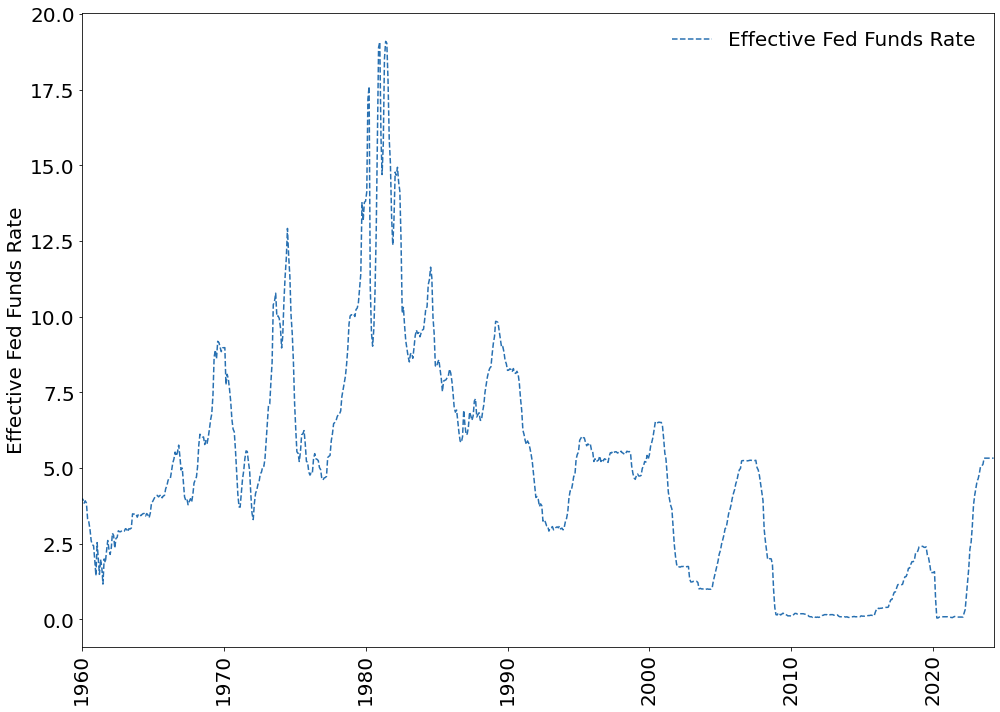

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(14, 10), sharex=True)       

axs.plot(ffr['DATE'].values, ffr['FEDFUNDS'].values, color=sns.color_palette("RdBu", n_colors=7)[6], linestyle='dashed', label=f'Effective Fed Funds Rate')
axs.set_ylabel("Effective Fed Funds Rate", fontsize=20)
axs.legend(loc=1, frameon=False, fontsize=20)

axs.set_xlim([pd.to_datetime('1960-01-01'), pd.to_datetime('2024-04-01')])
plt.setp(axs.get_xticklabels(), rotation=90, fontsize=20)
plt.setp(axs.get_yticklabels(),  fontsize=20)
fig.tight_layout()

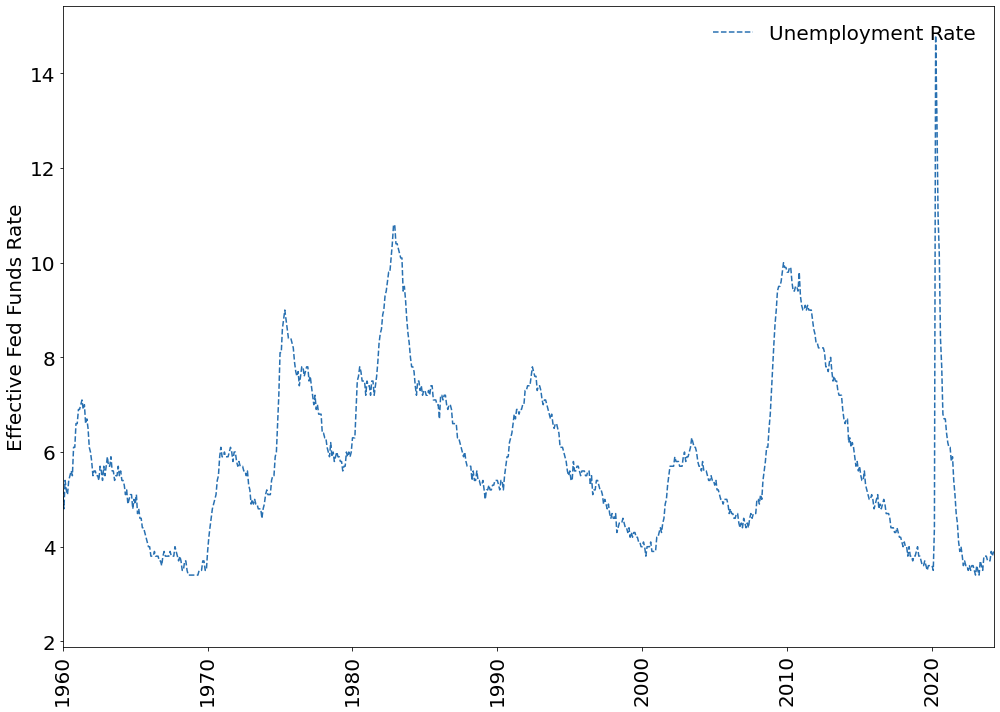

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(14, 10), sharex=True)       

axs.plot(unemp['DATE'].values, unemp['UNRATE'].values, color=sns.color_palette("RdBu", n_colors=7)[6], linestyle='dashed', label=f'Unemployment Rate')
axs.set_ylabel("Effective Fed Funds Rate", fontsize=20)
axs.legend(loc=1, frameon=False, fontsize=20)

axs.set_xlim([pd.to_datetime('1960-01-01'), pd.to_datetime('2024-04-01')])
plt.setp(axs.get_xticklabels(), rotation=90, fontsize=20)
plt.setp(axs.get_yticklabels(),  fontsize=20)
fig.tight_layout()

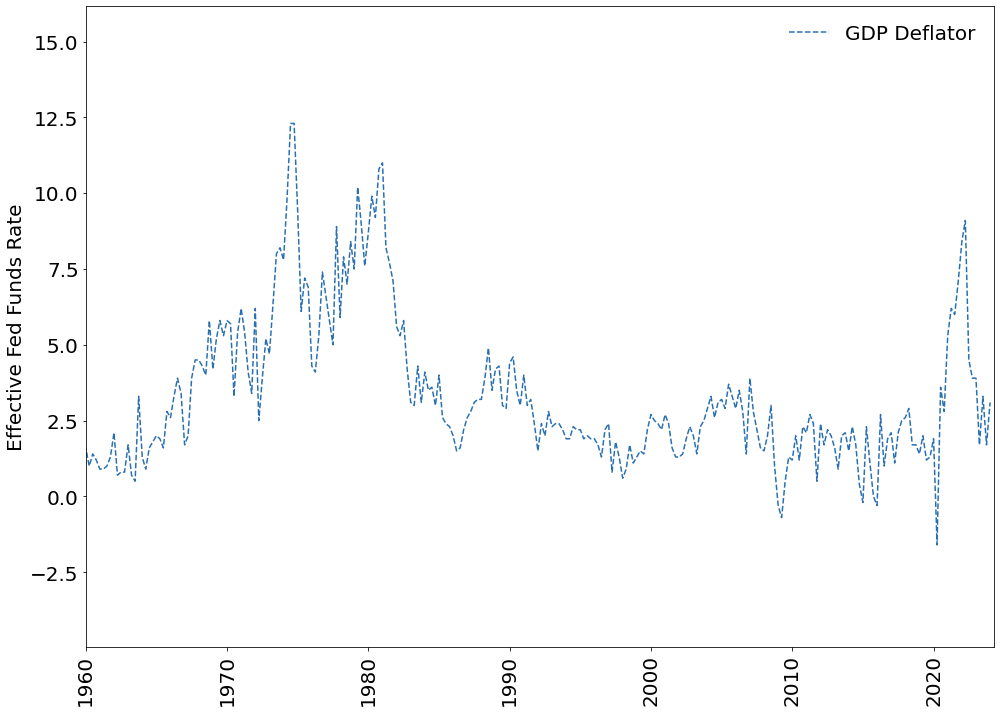

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(14, 10), sharex=True)       

axs.plot(gdpdeflator['DATE'].values, gdpdeflator['A191RI1Q225SBEA'].values, color=sns.color_palette("RdBu", n_colors=7)[6], linestyle='dashed', label=f'GDP Deflator')
axs.set_ylabel("Effective Fed Funds Rate", fontsize=20)
axs.legend(loc=1, frameon=False, fontsize=20)

axs.set_xlim([pd.to_datetime('1960-01-01'), pd.to_datetime('2024-04-01')])
plt.setp(axs.get_xticklabels(), rotation=90, fontsize=20)
plt.setp(axs.get_yticklabels(),  fontsize=20)
fig.tight_layout()

# aggregate to quarter

In [7]:
ffr.index = ffr['DATE']
ffr['Quarter'] = ffr.index.quarter
ffr['QUARTER'] = ffr['DATE'].astype('str').str[0:4] + 'Q' + ffr['Quarter'].astype('str').str[0]

unemp.index = unemp['DATE']
unemp['Quarter'] = unemp.index.quarter
unemp['QUARTER'] = unemp['DATE'].astype('str').str[0:4] + 'Q' + unemp['Quarter'].astype('str').str[0]

gdpdeflator.index = gdpdeflator['DATE']
gdpdeflator['Quarter'] = gdpdeflator.index.quarter
gdpdeflator['QUARTER'] = gdpdeflator['DATE'].astype('str').str[0:4] + 'Q' + gdpdeflator['Quarter'].astype('str').str[0]
gdpdeflator['GDPDFT'] = gdpdeflator['A191RI1Q225SBEA']


In [8]:
df_ffr = ffr.groupby('QUARTER').agg({'FEDFUNDS':'mean'}).reset_index()
df_unemp = unemp.groupby('QUARTER').agg({'UNRATE':'mean'}).reset_index()
df_gdpdft = gdpdeflator.groupby('QUARTER').agg({'GDPDFT':'mean'}).reset_index()

In [9]:
df_Q = pd.merge(df_gdpdft, df_unemp, how = 'inner')
df_Q = pd.merge(df_Q, df_ffr, how = 'inner')
df_Q['YEAR'] = df_Q['QUARTER'].str[0:4].astype('int')

In [10]:
df_Q.loc[(1960<= df_Q['YEAR']) & (df_Q['YEAR'] <= 2007), ['QUARTER', 'GDPDFT',   'UNRATE',    'FEDFUNDS'   ]].to_csv('series.csv', index = False)

# VAR

In [11]:
###############
# module
###############
from statsmodels.tsa.api import VAR
Y = df_Q.loc[(1960<= df_Q['YEAR']) & (df_Q['YEAR'] <= 2007), ['GDPDFT',   'UNRATE',    'FEDFUNDS'   ]]
estmdl = VAR(Y).fit(4)
estmdl.summary()

/Users/ygnmax/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 21, May, 2024
Time:                     18:16:50
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -2.74823
Nobs:                     188.000    HQIC:                  -3.14759
Log likelihood:          -439.837    FPE:                  0.0327467
AIC:                     -3.41962    Det(Omega_mle):       0.0267950
--------------------------------------------------------------------
Results for equation GDPDFT
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.911966         0.352617            2.586           0.010
L1.GDPDFT           0.575805         0.075785            7.598           0.000
L1.UNRATE          -0.754976         0.370011           -2.040     

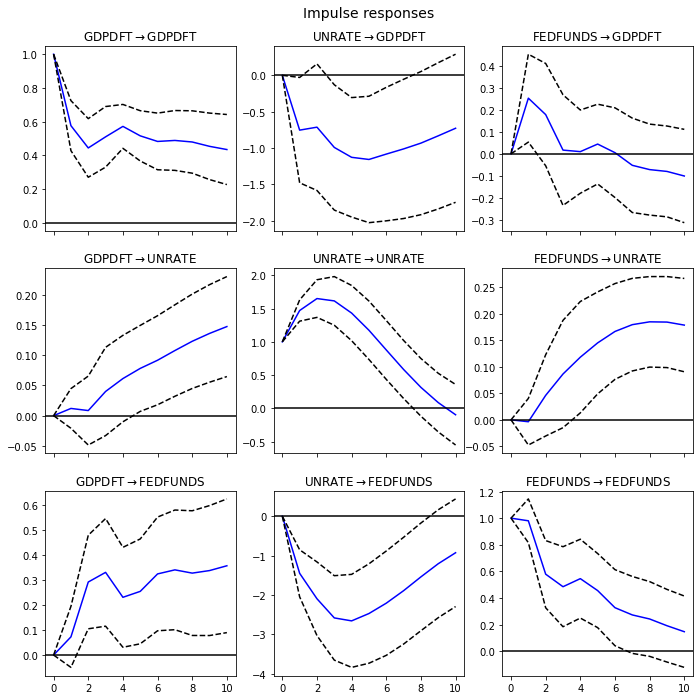

In [12]:
irf = estmdl.irf(10)
irffigure1 = irf.plot(orth=False)

In [13]:
###############
# matrix
###############
df_Q1 = df_Q.loc[(1960<= df_Q['YEAR']) & (df_Q['YEAR'] <= 2007), ['QUARTER', 'GDPDFT', 'UNRATE', 'FEDFUNDS', 'YEAR']]
for t in range(1,5):
    df_Q1[f'GDPDFT_L{t}'] = df_Q1['GDPDFT'].shift(t)
    df_Q1[f'UNRATE_L{t}'] = df_Q1['UNRATE'].shift(t)
    df_Q1[f'FEDFUNDS_L{t}'] = df_Q1['FEDFUNDS'].shift(t)
df_Q1 = df_Q1.dropna(how = 'any')
X = df_Q1.loc[(1960<= df_Q1['YEAR']) & (df_Q1['YEAR'] <= 2007), ['GDPDFT_L1','UNRATE_L1', 'FEDFUNDS_L1', 
                                                                 'GDPDFT_L2','UNRATE_L2', 'FEDFUNDS_L2',
                                                                 'GDPDFT_L3','UNRATE_L3', 'FEDFUNDS_L3',
                                                                 'GDPDFT_L4','UNRATE_L4', 'FEDFUNDS_L4']].values
X = np.hstack([np.ones((X.shape[0], 1)), X])

Y = df_Q1.loc[(1960<= df_Q1['YEAR']) & (df_Q1['YEAR'] <= 2007), ['GDPDFT',   'UNRATE',    'FEDFUNDS'   ]].values

# OLS estimation
XtX = np.dot(X.T, X)
XtX_inv = np.linalg.inv(XtX)
XtY = np.dot(X.T, Y)
coef = np.dot(XtX_inv, XtY)

print("Estimated Coefficients Matrix:")
print(coef)

Estimated Coefficients Matrix:
[[ 9.11965862e-01  1.47180541e-01  3.82081678e-01]
 [ 5.75805014e-01  1.19115677e-02  7.29772084e-02]
 [-7.54976121e-01  1.47054972e+00 -1.44995302e+00]
 [ 2.52184497e-01 -3.55205717e-03  9.80325222e-01]
 [ 1.02639349e-01 -1.57054258e-02  1.96607445e-01]
 [ 1.19646325e+00 -5.08324302e-01  1.51279581e+00]
 [-2.17424498e-01  5.19018572e-02 -4.04848527e-01]
 [ 1.29120326e-01  3.46483781e-02 -7.73841860e-02]
 [-8.04550049e-01  1.89223423e-04 -7.45508901e-01]
 [-5.36820545e-03 -3.02562468e-02  3.24022750e-01]
 [ 1.68426430e-01 -2.40986494e-02 -2.43106083e-02]
 [ 2.28947502e-01 -2.17713991e-02  5.91304850e-01]
 [-3.45897921e-02  9.70930195e-03  2.33899701e-02]]


In [14]:
residuals = Y - X @ coef
res_demean = residuals - residuals.mean(0)
sigma2 = np.dot(res_demean.T, res_demean)/ len(res_demean)
sigma2

array([[ 0.94582172, -0.00455476,  0.12383352],
       [-0.00455476,  0.04602027, -0.07753831],
       [ 0.12383352, -0.07753831,  0.64166997]])

# SVAR

In [57]:
L = np.linalg.cholesky(sigma2)
print("Lower Triangular Matrix L:")
print(L)
e = np.eye(3)
A = e**(1/2) @ np.linalg.inv(L)
print("Matrix A:")
print(A)

Lower Triangular Matrix L:
[[ 0.97253366  0.          0.        ]
 [-0.00468339  0.21447222  0.        ]
 [ 0.12733083 -0.35875027  0.70480854]]
Matrix A:
[[ 1.02824205e+00  0.00000000e+00  0.00000000e+00]
 [ 2.24535404e-02  4.66260853e+00 -3.09469603e-16]
 [-1.74333450e-01  2.37328574e+00  1.41882504e+00]]
